# Symbolic Regression through Genetic Programming 
## Importing relevant packages

In [49]:
!pip install deap

In [50]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
%cd /content/drive/MyDrive/Random/Symbolic-Regression

/content/drive/MyDrive/Random/Symbolic-Regression


In [52]:
import math, random, operator
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from deap import algorithms, base, creator, tools, gp
from sympy import sympify
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Data Prep
### Pulling Data In

In [53]:
data1 = pd.read_csv("data1.csv")
data2 = pd.read_csv("data2.csv")

### Splitting Data

In [54]:
train1, test1 = train_test_split(data1, test_size=0.2, shuffle=True)
train2, test2 = train_test_split(data2, test_size=0.2, shuffle=True)

## Defining Operations

In [55]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
def create_pset(data_set):
    rand_integer = random.randint(1,1234238)
    eph_name = "rand1_" + str(rand_integer) 
    pi_name = "randpi_" + str(random.randint(1,12342434))
    euler_name = "rande_" + str(random.randint(1,12342434))
    n_var = len(data_set.columns) - 1
    pset = gp.PrimitiveSet("MAIN", n_var)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)    
    pset.addEphemeralConstant(eph_name, lambda: random.randint(-50,50))
    pset.addEphemeralConstant(pi_name, lambda: random.randint(-10,10)*math.pi)
    pset.addEphemeralConstant(euler_name, lambda: random.randint(-10,10)*math.e)
    return pset

## Fitness Function

In [56]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    y_set = points['y'].to_numpy()
    x_set = points[points.columns.difference(['y'])].to_numpy()

    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(*x.tolist()) - y)**2 for x,y in zip(x_set, y_set))
    return math.fsum(sqerrors) / len(points),

## GP Execution Data Set 1

In [39]:
means = []
mins = []
variation = []
best_solutions  = []
best_fitness = []
for i in tqdm(range(30)):
    pset = create_pset(train1)
    ## Fitness function
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    toolbox.register("evaluate", evalSymbReg, points = train1)
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.4, fitness_first=False)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7))
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("var", np.var)
    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, 
                                         mu = 300,
                                         lambda_ = 300,
                                         cxpb = 0.7,
                                         mutpb = 0.3,
                                         ngen = 2000,
                                         stats = stats, 
                                         halloffame = hof,
                                         verbose = False)
    minFitnessValues, avgFitnessValues, varFitnessValues = log.select("min", "avg", "var")
    means.append(avgFitnessValues)
    mins.append(minFitnessValues)
    variation.append(varFitnessValues)
    best = hof.items[0]
    best_solutions.append(hof.items[0])
    best_fitness.append(hof.items[0].fitness.values[0])
    # print log

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


### Expression

In [40]:
best_val = min(best_fitness)
i = best_fitness.index(best_val)
best_solution = best_solutions[i]
operatorDict = {
    'sub': lambda x, y : x - y,
    'protectedDiv': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
}
expr = sympify(str(best_solution) , locals=operatorDict)
expr = str(expr).replace("neg", "-").replace("_list","_list[i]").replace('ARG0', 'x1').replace('**', '^').replace('ARG1', 'x2').replace('ARG2', 'x3')
expr

'x1*(-3.8513679809308552e-15*x1*sin(17.84955592153876*x1) + 3.1415926535897953*x1 - 1.1576932704638757e-15*(50 - x1)/sin(x1) - 1.0329081215064714e-13)'

### Truth and Prediction Comparison

Squared Error On Training Set= 5.743693127845417e-20
Squared Error on Testing Set = 8.368735408203182e-20


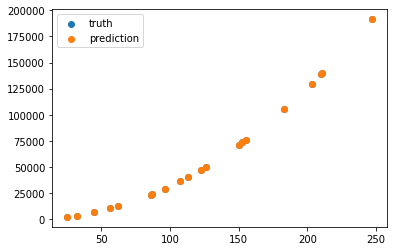

In [41]:
print("Squared Error On Training Set= " + str(best_solution.fitness.values[0]))
sq_error_test = evalSymbReg(best_solution, test1)
print("Squared Error on Testing Set = " + str(sq_error_test[0]))

func = toolbox.compile(expr=best_solution)
y_set = test1['y'].to_numpy()
x_set = test1[test1.columns.difference(['y'])].to_numpy()
features = []
prediction = []
truth = []
# Evaluate the mean squared error between the expression
# and the real function : x**4 + x**3 + x**2 + x
for x,y in zip(x_set, y_set):
    features.append(x[0])
    prediction.append(func(*x.tolist()))
    truth.append(y)
plt.scatter(features, truth, label='truth')
plt.scatter(features, prediction, label='prediction')
plt.legend()
plt.show()

### Convergence Analysis

(2001, 30)
(2001,)


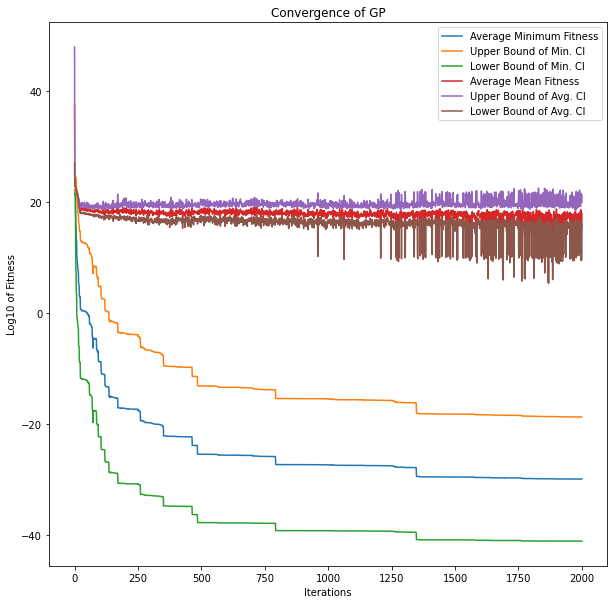

In [42]:
min_arr = np.array(mins)
min_arr = min_arr.T
print(min_arr.shape)
min_mean_arr = np.mean(np.log(min_arr), axis = 1)
print(min_mean_arr.shape)
min_std_arr = np.std(np.log(min_arr), axis = 1)
min_margin_of_error = min_std_arr * 2.756 / np.sqrt(30)
min_upper_bound = min_mean_arr + min_margin_of_error
min_lower_bound = min_mean_arr - min_margin_of_error

avg_arr = np.array(means)
avg_arr = avg_arr.T
avg_mean_arr = np.mean(np.log(avg_arr), axis = 1)
avg_std_arr = np.std(np.log(avg_arr), axis = 1)
avg_margin_of_error = avg_std_arr * 2.756 / np.sqrt(30)
avg_upper_bound = avg_mean_arr + avg_margin_of_error
avg_lower_bound = avg_mean_arr - avg_margin_of_error

plt.rcParams["figure.figsize"] = (10,10)

plt.plot(range(len(min_mean_arr)), min_mean_arr, label = "Average Minimum Fitness")
plt.plot(range(len(min_upper_bound)), min_upper_bound, label = "Upper Bound of Min. CI")
plt.plot(range(len(min_lower_bound)), min_lower_bound, label = "Lower Bound of Min. CI")
plt.plot(range(len(avg_mean_arr)), avg_mean_arr, label = "Average Mean Fitness")
plt.plot(range(len(avg_upper_bound)), avg_upper_bound, label = "Upper Bound of Avg. CI")
plt.plot(range(len(avg_lower_bound)), avg_lower_bound, label = "Lower Bound of Avg. CI")

plt.xlabel("Iterations")
plt.ylabel("Log10 of Fitness")
plt.title("Convergence of GP")
plt.legend()
plt.show()

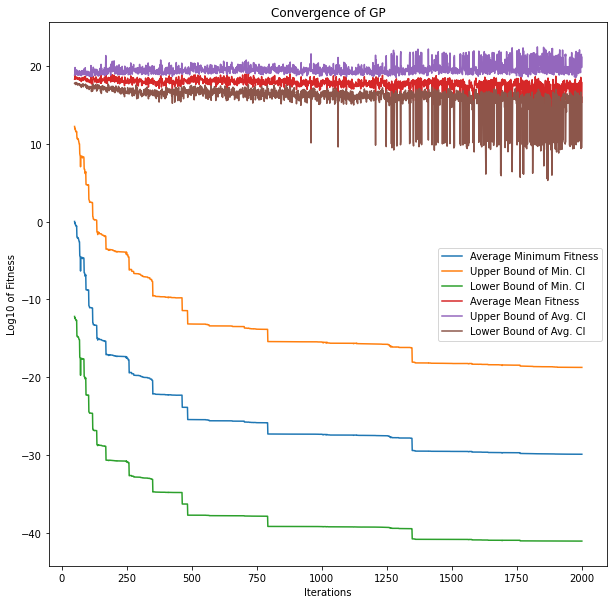

In [43]:
plt.rcParams["figure.figsize"] = (10,10)

plt.plot(range(50,len(min_mean_arr)), min_mean_arr[50:], label = "Average Minimum Fitness")
plt.plot(range(50,len(min_upper_bound)), min_upper_bound[50:], label = "Upper Bound of Min. CI")
plt.plot(range(50,len(min_lower_bound)), min_lower_bound[50:], label = "Lower Bound of Min. CI")
plt.plot(range(50,len(avg_mean_arr)), avg_mean_arr[50:], label = "Average Mean Fitness")
plt.plot(range(50,len(avg_upper_bound)), avg_upper_bound[50:], label = "Upper Bound of Avg. CI")
plt.plot(range(50,len(avg_lower_bound)), avg_lower_bound[50:], label = "Lower Bound of Avg. CI")

plt.xlabel("Iterations")
plt.ylabel("Log10 of Fitness")
plt.title("Convergence of GP")
plt.legend()
plt.show()

## GP Execution Data Set 2

In [57]:
means = []
mins = []
variation = []
best_solutions  = []
best_fitness = []
for i in tqdm(range(30)):
    pset = create_pset(train2)
    ## Fitness function
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    toolbox.register("evaluate", evalSymbReg, points = train2)
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.4, fitness_first=False)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7))
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("var", np.var)
    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, 
                                         mu = 300,
                                         lambda_ = 300,
                                         cxpb = 0.7,
                                         mutpb = 0.3,
                                         ngen = 2000,
                                         stats = stats, 
                                         halloffame = hof,
                                         verbose = False)
    minFitnessValues, avgFitnessValues, varFitnessValues = log.select("min", "avg", "var")
    means.append(avgFitnessValues)
    mins.append(minFitnessValues)
    variation.append(varFitnessValues)
    best = hof.items[0]
    best_solutions.append(hof.items[0])
    best_fitness.append(hof.items[0].fitness.values[0])
    # print log

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


### Expression

In [45]:
best_val = min(best_fitness)
i = best_fitness.index(best_val)
best_solution = best_solutions[i]
operatorDict = {
    'sub': lambda x, y : x - y,
    'protectedDiv': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
}
expr = sympify(str(best_solution) , locals=operatorDict)
expr = str(expr).replace("neg", "-").replace("_list","_list[i]").replace('ARG0', 'x1').replace('**', '^').replace('ARG1', 'x2').replace('ARG2', 'x3')
expr

'(2.1504989651573654*x2 - 0.13544181016371311*x3 + 16)/(-2*x2 + 1.318309886183791*x3 - 110.26548245743669)'

### Truth and Prediction Comparison

Squared Error On Training Set= 6.267898462730059e-07
Squared Error on Testing Set = 5.418983069288407e-07


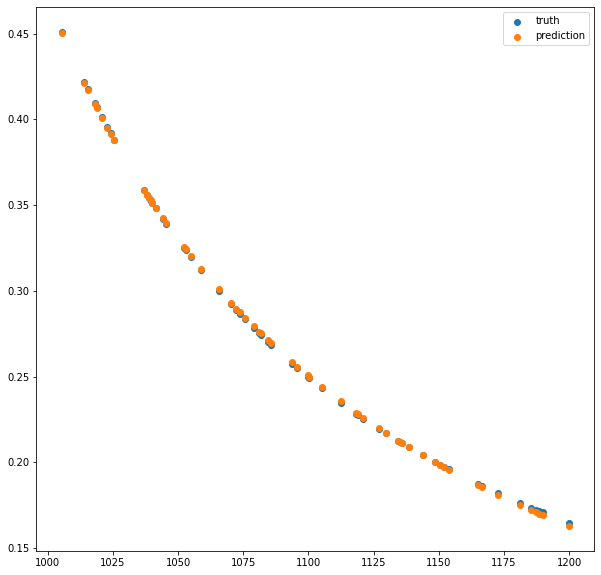

In [46]:
print("Squared Error On Training Set= " + str(best_solution.fitness.values[0]))
sq_error_test = evalSymbReg(best_solution, test2)
print("Squared Error on Testing Set = " + str(sq_error_test[0]))

func = toolbox.compile(expr=best_solution)
y_set = test2['y'].to_numpy()
x_set = test2[test2.columns.difference(['y'])].to_numpy()
features = []
prediction = []
truth = []
# Evaluate the mean squared error between the expression
# and the real function : x**4 + x**3 + x**2 + x
for x,y in zip(x_set, y_set):
    features.append(x[0])
    prediction.append(func(*x.tolist()))
    truth.append(y)
plt.scatter(features, truth, label='truth')
plt.scatter(features, prediction, label='prediction')
plt.legend()
plt.show()

### Convergence Analysis

(1001, 30)
(1001,)


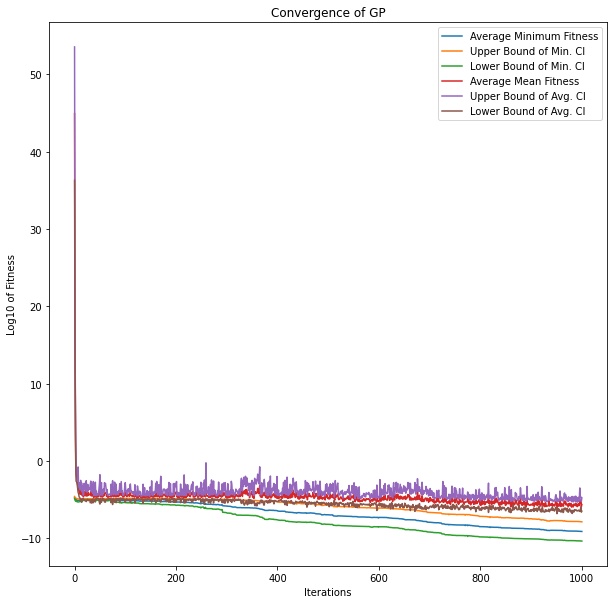

In [47]:
min_arr = np.array(mins)
min_arr = min_arr.T
print(min_arr.shape)
min_mean_arr = np.mean(np.log(min_arr), axis = 1)
print(min_mean_arr.shape)
min_std_arr = np.std(np.log(min_arr), axis = 1)
min_margin_of_error = min_std_arr * 2.756 / np.sqrt(30)
min_upper_bound = min_mean_arr + min_margin_of_error
min_lower_bound = min_mean_arr - min_margin_of_error

avg_arr = np.array(means)
avg_arr = avg_arr.T
avg_mean_arr = np.mean(np.log(avg_arr), axis = 1)
avg_std_arr = np.std(np.log(avg_arr), axis = 1)
avg_margin_of_error = avg_std_arr * 2.756 / np.sqrt(30)
avg_upper_bound = avg_mean_arr + avg_margin_of_error
avg_lower_bound = avg_mean_arr - avg_margin_of_error

plt.rcParams["figure.figsize"] = (10,10)

plt.plot(range(len(min_mean_arr)), min_mean_arr, label = "Average Minimum Fitness")
plt.plot(range(len(min_upper_bound)), min_upper_bound, label = "Upper Bound of Min. CI")
plt.plot(range(len(min_lower_bound)), min_lower_bound, label = "Lower Bound of Min. CI")
plt.plot(range(len(avg_mean_arr)), avg_mean_arr, label = "Average Mean Fitness")
plt.plot(range(len(avg_upper_bound)), avg_upper_bound, label = "Upper Bound of Avg. CI")
plt.plot(range(len(avg_lower_bound)), avg_lower_bound, label = "Lower Bound of Avg. CI")

plt.xlabel("Iterations")
plt.ylabel("Log10 of Fitness")
plt.title("Convergence of GP")
plt.legend()
plt.show()

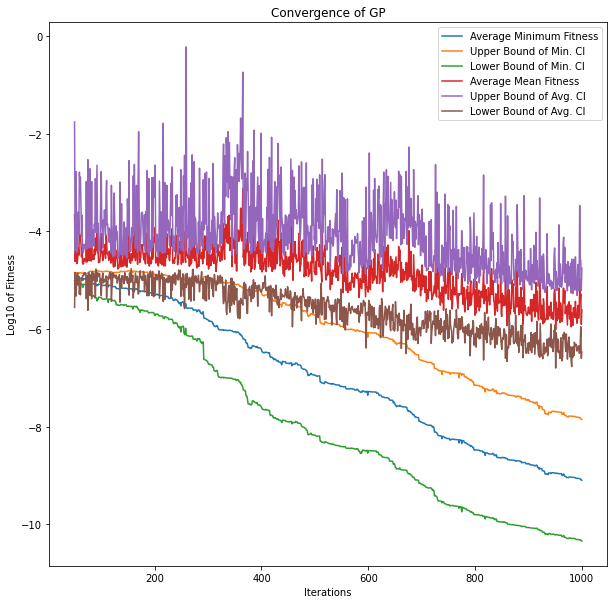

In [48]:
plt.rcParams["figure.figsize"] = (10,10)

plt.plot(range(50,len(min_mean_arr)), min_mean_arr[50:], label = "Average Minimum Fitness")
plt.plot(range(50,len(min_upper_bound)), min_upper_bound[50:], label = "Upper Bound of Min. CI")
plt.plot(range(50,len(min_lower_bound)), min_lower_bound[50:], label = "Lower Bound of Min. CI")
plt.plot(range(50,len(avg_mean_arr)), avg_mean_arr[50:], label = "Average Mean Fitness")
plt.plot(range(50,len(avg_upper_bound)), avg_upper_bound[50:], label = "Upper Bound of Avg. CI")
plt.plot(range(50,len(avg_lower_bound)), avg_lower_bound[50:], label = "Lower Bound of Avg. CI")

plt.xlabel("Iterations")
plt.ylabel("Log10 of Fitness")
plt.title("Convergence of GP")
plt.legend()
plt.show()